In [25]:
# база
import numpy as np
import pandas as pd
import warnings
import json
import string
import time

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')  # Загрузить необходимые ресурсы для токенизатора Punkt
from nltk.lm import Vocabulary

# sklearn
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# константы
RANDOM_SATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('Куда ?: ', torch.cuda.is_available())

Куда ?:  True


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oudel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Предподготовка датасета

- Разбиваем текст на предложения (nltk.sent_tokenize)

# Разбиваем текст на предложения (каждое предложение будет в списке)

In [26]:
with open('frank_eng.txt', 'r') as file:
    text = file.read()

список_предложений = sent_tokenize(text)
список_предложений[:10]

['Letter 1\nTo Mrs. Saville, England.',
 'St. Petersburgh, Dec. 11th, 17—.',
 'You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings.',
 'I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking.',
 'I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.',
 'Do you understand this feeling?',
 'This breeze, which has travelled from the regions towards which I am advancing, gives me a foretaste of those icy climes.',
 'Inspirited by this wind of promise, my daydreams become more fervent and vivid.',
 'I try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight.',
 'There, Margaret, the sun is f

# Нижний регистр + убираем пунктуацию

In [27]:
punctuation = string.punctuation + '“”—' +  '\n\t\r' # строка со всеми пунктуационными символами и специальными строковыми сиволами

def нижний_регистр__удаление_пунктуации_____для_цикла(предложение):
    предложение = предложение.lower()
    предложение = ''.join([token for token in предложение if token not in punctuation])
    return предложение

список_предложений = [нижний_регистр__удаление_пунктуации_____для_цикла(предложение)
                      for предложение in список_предложений]

список_предложений[:10]

['letter 1to mrs saville england',
 'st petersburgh dec 11th 17',
 'you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings',
 'i arrived here yesterday and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking',
 'i am already far north of london and as i walk in the streets of petersburgh i feel a cold northern breeze play upon my cheeks which braces my nerves and fills me with delight',
 'do you understand this feeling',
 'this breeze which has travelled from the regions towards which i am advancing gives me a foretaste of those icy climes',
 'inspirited by this wind of promise my daydreams become more fervent and vivid',
 'i try in vain to be persuaded that the pole is the seat of frost and desolation it ever presents itself to my imagination as the region of beauty and delight',
 'there margaret the sun is for ever visible its broad di

# Разбиваем предложения на токены с учетом модели CBOW (длина предложения должна быть не менее 5: 2 левых + 2 правых + 1 центральное)

In [28]:
список_предложений_в_виде_токенов = [предложение.split(' ') for предложение in список_предложений if len(предложение.split(' ')) >= 5]
список_предложений_в_виде_токенов[:2]

[['letter', '1to', 'mrs', 'saville', 'england'],
 ['st', 'petersburgh', 'dec', '11th', '17']]

# Создаем датасет + перемешиваем

In [29]:
data = {
    'левый блок': [], 
    'правый блок':[], 
    'метка (слово посередине)':[]
}


все_используемые_токены_из_текста = ''
for предложение_в_виде_токенов in список_предложений_в_виде_токенов:
    for i in range(5):
        корпус_из_5_слов = предложение_в_виде_токенов[i : i+5]
        if len(корпус_из_5_слов) > 4:
            все_используемые_токены_из_текста += ' '.join(корпус_из_5_слов) + ' '
            data['левый блок'].append(' '.join(корпус_из_5_слов[0:2]))
            data['правый блок'].append(' '.join(корпус_из_5_слов[3:5]))
            data['метка (слово посередине)'].append(корпус_из_5_слов[2])

# фрейм
df = pd.DataFrame(data=data).sample(frac=1, random_state = RANDOM_SATE).reset_index(drop=True)
# все уникальные токены
все_используемые_токены_из_текста = list(set(все_используемые_токены_из_текста.split(' ')))

df.head()

,левый блок,правый блок,метка (слово посередине)
0,resolved at,not to,least
1,anticipated with,joy so,such
2,that the,of attending,task
3,my infancy,was imbued,i
4,i was,led by,easily


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14089 entries, 0 to 14088
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   левый блок                14089 non-null  object
 1   правый блок               14089 non-null  object
 2   метка (слово посередине)  14089 non-null  object
dtypes: object(3)
memory usage: 330.3+ KB


# Создаем колонку split (train / val / test)

In [31]:
train, test = train_test_split(df.index.to_list(),
                               test_size = 0.3,
                               random_state = RANDOM_SATE)
val, test = train_test_split(test,
                             test_size = 0.5,
                             random_state = RANDOM_SATE)

print('Размерность тренировочного фрейма: {}'.format(len(train)))
print('Размерность валидационного фрейма: {}'.format(len(val)))
print('Размерность тестового фрейма: {}'.format(len(test)))

def label_column(x):
    if x in train:
        return 'train'
    if x in test:
        return 'test'
    else:
        return 'val'

df = df.reset_index()    
df['split'] = df['index'].map(lambda x: label_column(x))
df = df.drop('index', axis = 1)
df.head()


Размерность тренировочного фрейма: 9862
Размерность валидационного фрейма: 2113
Размерность тестового фрейма: 2114


,левый блок,правый блок,метка (слово посередине),split
0,resolved at,not to,least,val
1,anticipated with,joy so,such,train
2,that the,of attending,task,train
3,my infancy,was imbued,i,val
4,i was,led by,easily,train


In [32]:
df['split'].value_counts()

split
train    9862
test     2114
val      2113
Name: count, dtype: int64

# Vocabulary

In [33]:
class Frank_Vocabulary(object):
    def __init__(self, df):
         self.df = df

    def create_vocab(self):
            data_to_vocab = self.df[self.df['split'] == 'train']
            full_train_stroka = ''
            for index, row in data_to_vocab.iterrows():
                full_train_stroka += ' ' + row['левый блок'] + ' ' + row['правый блок'] + ' ' + row['метка (слово посередине)']

            spisok_tokenov = sorted(full_train_stroka.split(' ')[1:])
            vocab_token_index = Vocabulary(spisok_tokenov, unk_cutoff = 2)
            vocab_token_index = list(vocab_token_index)
            vocab_token_index.insert(-1, '<MASK>')
            self.vocab_token_index = dict(zip(vocab_token_index,
                                              [int(i) for i in np.arange(0, len(vocab_token_index))]))

            self.vocab_index_token = {}
            for token, index in self.vocab_token_index.items():
                self.vocab_index_token[index] = token
            print('Длина словаря вместе с <MASK> и <UNK> токенами: {}'.format(len(self.vocab_token_index)))

            return self.vocab_token_index, self.vocab_index_token


    def save_vocab(self):
        with open('vocab_token_to_index.json', 'w') as file:
                    json.dump(self.vocab_token_index, file)
        with open('vocab_index_to_token.json', 'w') as file:
                    json.dump(self.vocab_index_token, file)
        print('Словари сохранены в открытой директории')
            
    def return_index(self, token):
           return self.vocab_token_index.get(token)
    
    def return_token(self, index):
           return self.vocab_token_index.get(index)
    
    def len(self):
           return len(self.vocab_token_index)

# Dataset

In [34]:
class FrankDataset(Dataset):
    def __init__(self, df, mode):
        """
        Args:
            df (pandas.DataFrame): фрейм
            mode (str): train / val / test

        """
        self.df_mode = df[df.split == mode]
        self.size_df = len(self.df_mode)
        self.vocab = Frank_Vocabulary(self.df_mode)
        if mode != 'train':
            with open('vocab_token_to_index.json', 'r') as file:
                self.vocab_token_index = json.load(file)
            with open('vocab_index_to_token.json', 'r') as file:
                self.vocab_index_token = json.load(file)
        else:
            self.vocab_token_index, self.vocab_index_token = self.vocab.create_vocab()
            self.vocab.save_vocab()
    
    def __len__(self):
        return self.size_df

    def __getitem__(self, index):

        row = self.df_mode.iloc[index]
        unk_index = self.vocab_token_index.get('<UNK>')

        label = self.vocab_token_index.get(row['метка (слово посередине)'], unk_index)
        row = row['левый блок'] + ' ' +\
              '<MASK>' + ' ' +\
              row['правый блок']
        token_list = row.split(' ')
        
        features = [self.vocab_token_index.get(token_str, unk_index) for token_str in token_list]

        return np.array(features),  np.array(label)


# Model

In [35]:
class WordPredictionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(WordPredictionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 5, vocab_size)

    def forward(self, input_data):
        embedded_input = self.embedding(input_data)
        flattened = embedded_input.view(input_data.size(0), -1)  # Выравнивание для полносвязного слоя
        output = self.fc(flattened)  # Предсказание слова в центре контекста
        
        return output

# Функция L1_L2 регуляризации

In [36]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

# Training loop

In [37]:
def training_loop(
        epoches,
        model,
        optimizer,
        scheduler_append,
        scheduler,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_val_list = []
    acc_train_list = []
    acc_val_list = []

    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()
            loss_train = 0
            loss_val = 0

            correct_train_acc = 0
            correct_val_acc = 0
            total_train_acc = 0
            total_val_acc = 0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer:
                        loss = loss_with_l1_or_l2_regulizer(model = model,
                                                        type = reg_type,
                                                        l_lambda = 0.001,
                                                        loss_by_fn = loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                
                ########  Расчет тренировочной accuracy  #########
                outputs = torch.softmax(outputs, dim = 1)
                _ , predict_labels = torch.max(outputs,1)
                total_train_acc += labels.size(0)
                correct_train_acc += (predict_labels == labels).sum().item()
                ##################################################

            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
            train_acc = correct_train_acc / total_train_acc
            acc_train_list.append(train_acc)
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels in val_dataloader:
                                        features = features.to(device)
                                        labels = labels.type(torch.LongTensor).to(device)
                                        outputs = model(features)
                                        loss_on_val = loss_fn(outputs, labels)
                                        loss_val += loss_on_val.item()
                                        
                                        ########  Расчет валидационной accuracy  #########
                                        outputs = torch.softmax(outputs, dim = 1)
                                        _ , predict_labels = torch.max(outputs,1)
                                        total_val_acc += labels.size(0)
                                        correct_val_acc += (predict_labels == labels).sum().item()
                                        ##################################################

                                mean_epoch_loss_val = loss_val / len(val_dataloader)
                                loss_val_list.append(mean_epoch_loss_val)
                                val_acc = correct_val_acc / total_val_acc
                                acc_val_list.append(val_acc)
                                
            # EARLY STOPPING #######################################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):

                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                if len(loss_val_list) >= each__X__epoch:
                        past = loss_val_list[-each__X__epoch]
                        now = loss_val_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
            ##############################################################
            if scheduler_append:
                scheduler.step(mean_epoch_loss_val)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train accuracy: {:.3f} || val accuracy: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss,
                                mean_epoch_loss_val,
                                train_acc,
                                val_acc
                                )     
                      )
            ################################################################
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_val_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}'.format(epoches))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = acc_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = acc_val_list,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('accuracy')
    plt.title('accuracy per epoch'.format(epoches))
    plt.legend()
    plt.grid()
    plt.show()
    
    return model

In [38]:
vocab_class = Frank_Vocabulary(df)
vocab_class.create_vocab()

vocabulary_size = vocab_class.len()
embedding_dim = 50

train_dataloader = DataLoader(dataset = FrankDataset(df = df,
                                                     mode = 'train'),
                              batch_size = 128,
                              shuffle = False)


val_dataloader = DataLoader(dataset = FrankDataset(df = df,
                                                   mode = 'val'),
                            batch_size = 128,
                            shuffle = False)

Длина словаря вместе с <MASK> и <UNK> токенами: 3046
Длина словаря вместе с <MASK> и <UNK> токенами: 3046
Словари сохранены в открытой директории


# Проверка работоспособности модели

In [39]:
model = WordPredictionModel(vocab_size = vocabulary_size,
                            embedding_dim = embedding_dim)
values =\
np.vstack((np.array(train_dataloader.dataset[0][0]),
           np.array(train_dataloader.dataset[1][0])))

outputs =\
model(torch.tensor(values))

outputs

tensor([[ 0.2836, -0.7168,  0.1460,  ..., -0.2210,  0.5595, -1.0355],
        [-0.6733, -0.2207,  0.1132,  ..., -0.1055,  0.7879,  0.0996]],
       grad_fn=<AddmmBackward0>)

In [40]:
softmax_predicted = torch.softmax(outputs, dim = 1)
softmax_predicted

tensor([[0.0004, 0.0001, 0.0003,  ..., 0.0002, 0.0005, 0.0001],
        [0.0001, 0.0002, 0.0003,  ..., 0.0002, 0.0006, 0.0003]],
       grad_fn=<SoftmaxBackward0>)

In [41]:
_ , idx_max = torch.max(softmax_predicted,1)
idx_max

tensor([2646, 1767])

# Тренировка модели

Длина словаря вместе с <MASK> и <UNK> токенами: 3046
Словари сохранены в открытой директории
Расчетное время выполнения всего цикла 60.871 минут
Epoch     1/ 5000 || time: 0.730 || train loss: 7.088 || val_loss: 6.338 || train accuracy: 0.046 || val accuracy: 0.083
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 100 эпохе пришлось остановить обучение
loss_100_эпохи >= loss_0_эпохи


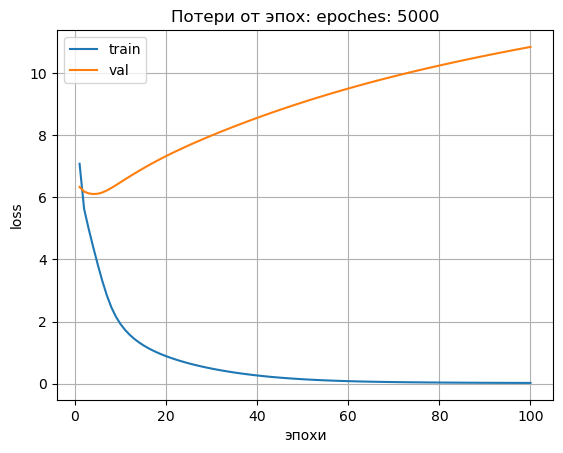

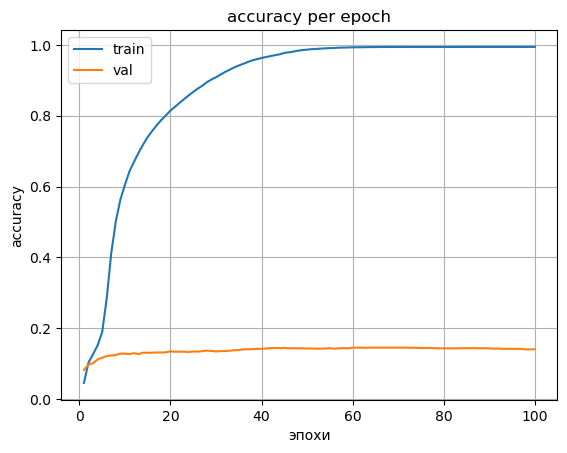

In [42]:
# %%script False

vocab_size = 3240
embedding_dim = 50


train_dataloader = DataLoader(dataset = FrankDataset(df = df,
                                                     mode = 'train'),
                              batch_size = 128,
                              drop_last = True, 
                              shuffle = False)


val_dataloader = DataLoader(dataset = FrankDataset(df = df,
                                                   mode = 'val'),
                            batch_size = 128,
                            drop_last = True,
                            shuffle = False)

# Использование модели
model = WordPredictionModel(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.5, threshold=0.001, verbose=True)


model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler_append = False,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = False,
    reg_type = 'l1',
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Проверка на тестовой выборке

In [ ]:
test_dataset = FrankDataset(df = df,mode = 'test')
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = test_dataset.size_df,
                             shuffle = False)

In [54]:
total_test_acc = 0
correct_test_acc = 0

model.eval()
with torch.no_grad():
    for features, labels in test_dataloader:
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            outputs = model(features)
            ########  Расчет валидационной accuracy  #########
            outputs = torch.softmax(outputs, dim = 1)
            _ , predict_labels = torch.max(outputs,1)
            total_test_acc += labels.size(0)
            correct_test_acc += (predict_labels == labels).sum().item()
            ##################################################


test_acc = correct_test_acc / total_test_acc
test_acc

0.14380321665089876